Reading the dataset from the Google Sheets

In [0]:
import pandas as pd
import numpy as np 

dataset = pd.read_csv('https://drive.google.com/' + 
                   'uc?id=1xz08-XSlUjkjYbjsvXfo88uGvai12_SD&export=download')

X_shape_view = dataset.iloc[:,1:10].values
X_RGB_view = dataset.iloc[:,10:21].values
X_full_view = dataset.iloc[:,1:21].values


# Dropping the third and fourth column because it hasn't much variation 
X_full_view = np.delete(X_full_view, [2,4], 1)
X_shape_view = np.delete(X_shape_view, [2,4], 1)

y = dataset.iloc[:,0].values

Gaussian Bayesian Classifier.

In [0]:
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

class GaussianBayesClassifier:
  
  def __init__(self):
    self.classes_ = None
    self.a_priori_probabilities_ = None
    self.thetas_ = None
    self.sigmas_ = None

      
  def fit(self, X, y):
    #initializing
    # suppose to come always in alphabetical order. if some error raise, check again
    self.classes_ = np.unique(y)
    self.thetas_ = []
    self.a_priori_probabilities_ = []
    self.sigmas_ = []
    
    n_samples = np.shape(X)[0]
      
    for y_i in self.classes_:
      class_indexes = y == y_i
      X_distribution = X[class_indexes,:]
      
      mean_values = np.mean(X_distribution, axis=0)
      variance_values = np.var(X_distribution, axis=0)  
      variance_matrix = np.diag(variance_values)
      
      self.thetas_.append(mean_values)
      self.sigmas_.append(variance_matrix)
      self.a_priori_probabilities_.append(np.count_nonzero(class_indexes)/n_samples)
     
    return self
  
    
  def _get_likelihood(self, X):
    predicted_values = []
    accumulated_amount = 0
    for i, y_i in enumerate(self.classes_):
      a_priori_proba = self.a_priori_probabilities_[i]
      density = multivariate_normal(mean=self.thetas_[i], cov=self.sigmas_[i])
      coeficient = density.pdf(X)*a_priori_proba
      
      predicted_values.append(coeficient)
      accumulated_amount += coeficient
     
    return (1/accumulated_amount)*np.array(predicted_values)
    
  def score(self, X, y_true):
    predicts = []
    for x in X:
      predicts.append(self.predict(x))
   
    return accuracy_score(y_true, predicts)

    
  def predict(self, X):
    if self.classes_ is None:
      raise ValueError('O modelo ainda não foi treinado')
    
    llh = self._get_likelihood(X)
    return self.classes_[np.argmax(llh)]
 
  def predict_proba(self, X):
    if self.classes_ is None:
      raise ValueError('O modelo ainda não foi treinado')
   
    llh = self._get_likelihood(X)
    return llh
  
 

KNN Classifier with validation of the parameter k

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class KNNWithValidation:
  
  def __init__(self):
    self.k_values = np.arange(1, 31, 2)
    self.classifier = None
    
  def fit(self, X, y):
    
    maximum_score = 0
    k_index = 0
    # again split the training dataset in 80-20(validation)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y,
                                                          test_size=0.2)
    for i,k in enumerate(self.k_values):
      knn_c = KNeighborsClassifier(n_neighbors=k, weights='distance')
      knn_c.fit(X_train, y_train)
      
      predicts = knn_c.predict(X_validation)
      score = accuracy_score(y_validation, predicts)
      if score > maximum_score:
        maximum_score = score
        k_index = i
        
    self.classifier = KNeighborsClassifier(n_neighbors=self.k_values[k_index], weights='distance')
    self.classifier.fit(X,y)
  
  def score(self, X, y_true):
    predicts = self.classifier.predict(X)
    return accuracy_score(y_true, predicts)
  
  def predict_proba(self, X):
    if self.classifier is None:
      raise ValueError('O classificador não foi treinado')
    
    return self.classifier.predict_proba(X)[0]

Classifier given by the composition kNN, bayes e as diferentes views.

In [0]:
class ComposedClassifier:
  
  def __init__(self):
    self.classes =  None
    self.a_priori_probabilities = None
  
  def fit(self, knn_classifier_full, bayes_classifier_full, knn_classifier_shape, bayes_classifier_shape, knn_classifier_rgb, bayes_classifier_rgb):
    
    # Setting full view
    self.knn_classifier_full = knn_classifier_full
    
    self.bayes_classifier_full = bayes_classifier_full
    
    # Setting shape view
    self.knn_classifier_shape = knn_classifier_shape
    
    self.bayes_classifier_shape = bayes_classifier_shape
    
    # Setting RGB view
    self.knn_classifier_rgb = knn_classifier_rgb
    
    self.bayes_classifier_rgb = bayes_classifier_rgb
    
    # setting classes and a priori probabilities
    # it could be any of the bayes classifiers, it is the same
    self.classes = self.bayes_classifier_full.classes_
    self.a_priori_probabilities = self.bayes_classifier_full.a_priori_probabilities_
    
    
  def predict(self, x_full, x_shape, x_rgb):
    
    train_status = [
        self.knn_classifier_full is None,
        self.bayes_classifier_full is None,
        self.knn_classifier_shape is None,
        self.bayes_classifier_shape is None,
        self.knn_classifier_rgb is None,
        self.bayes_classifier_rgb is None,
        self.classes is None,
        self.a_priori_probabilities is None
                   ]
    if any(train_status):
        raise ValueError('Classificador não foi treinado')
    
    llh = self._get_likelihood(x_full, x_shape, x_rgb)
    return self.classes[np.argmax(llh)]
  
  
  def _get_likelihood(self, x_full, x_shape, x_rgb):
    
    ## Predicted Probabilities
    full_knn_proba = self.knn_classifier_full.predict_proba([x_full])
    full_bayes_proba = self.bayes_classifier_full.predict_proba([x_full])
    
    rgb_knn_proba = self.knn_classifier_rgb.predict_proba([x_rgb])
    rgb_bayes_proba = self.bayes_classifier_rgb.predict_proba([x_rgb])
    
    shape_knn_proba = self.knn_classifier_shape.predict_proba([x_shape])
    shape_bayes_proba = self.bayes_classifier_shape.predict_proba([x_shape])
    
    
    predicted_probabilities = []
    ## End Predicted Probabilities
    for i, y_i in enumerate(self.classes):
      prior_term = -2*self.a_priori_probabilities[i]
      classifier_term = 3*max(
          full_knn_proba[i],
          full_bayes_proba[i],
          rgb_knn_proba[i],
          rgb_bayes_proba[i],
          shape_knn_proba[i],
          shape_bayes_proba[i]
      )
      
     
      predicted_probabilities.append(prior_term + classifier_term)
      
    return predicted_probabilities
    

  def score(self, X_full, X_shape, X_rgb, y_true):
    
    predicted_labels = []
    for i, x_f in enumerate(X_full):
      predicted_labels.append(self.predict(X_full[i,:], X_shape[i,:], X_rgb[i,:])) 
      
    return accuracy_score(y_true, predicted_labels)

30 times 10-Fold Cross Validation to get the respectives metrics

In [5]:
from sklearn.model_selection import StratifiedKFold

def runStratifiedKFold():
  
  skf = StratifiedKFold(n_splits=10, shuffle=True)

  precisions_gaussian_full = []
  precisions_knn_full = []

  precisions_gaussian_rgb = []
  precisions_knn_rgb = []

  precisions_gaussian_shape = []
  precisions_knn_shape = []

  precisions_composed_classifier = []

  for train_index, test_index in skf.split(X_shape_view, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_full_train, X_full_test = X_full_view[train_index], X_full_view[test_index]
    X_rgb_train, X_rgb_test = X_RGB_view[train_index], X_RGB_view[test_index]
    X_shape_train, X_shape_test = X_shape_view[train_index], X_shape_view[test_index]

    y_train, y_test = y[train_index], y[test_index]

    ###### full
    bayes_classifier_full = GaussianBayesClassifier()
    bayes_classifier_full.fit(X_full_train, y_train)
    score_gaussian_full = bayes_classifier_full.score(X_full_test, y_test)
    precisions_gaussian_full.append(score_gaussian_full)

    knn_classifier_full = KNNWithValidation()
    knn_classifier_full.fit(X_full_train, y_train)
    score_knn_full = knn_classifier_full.score(X_full_test, y_test)
    precisions_knn_full.append(score_knn_full)

    ##### full

    ###### rgb

    bayes_classifier_rgb = GaussianBayesClassifier()
    bayes_classifier_rgb.fit(X_rgb_train, y_train)
    score_gaussian_rgb = bayes_classifier_rgb.score(X_rgb_test, y_test)
    precisions_gaussian_rgb.append(score_gaussian_rgb)

    knn_classifier_rgb = KNNWithValidation()
    knn_classifier_rgb.fit(X_rgb_train, y_train)
    score_knn_rgb = knn_classifier_rgb.score(X_rgb_test, y_test)
    precisions_knn_rgb.append(score_knn_rgb)

    ##### rgb

    ##### shape
    bayes_classifier_shape = GaussianBayesClassifier()
    bayes_classifier_shape.fit(X_shape_train, y_train)
    score_gaussian_shape = bayes_classifier_shape.score(X_shape_test, y_test)
    precisions_gaussian_shape.append(score_gaussian_shape)

    knn_classifier_shape = KNNWithValidation()
    knn_classifier_shape.fit(X_shape_train, y_train)
    score_knn_shape = knn_classifier_shape.score(X_shape_test, y_test)
    precisions_knn_shape.append(score_knn_shape)

    ##### shape

    #### composed
    composed_classifier = ComposedClassifier()
    composed_classifier.fit(knn_classifier_full, bayes_classifier_full, knn_classifier_shape, bayes_classifier_shape, knn_classifier_rgb, bayes_classifier_rgb)

    score_composed_classifier = composed_classifier.score(X_full_test, X_shape_test, X_rgb_test, y_test)
    precisions_composed_classifier.append(score_composed_classifier)
    #### composed



  means = []
  deviations = []

  means.append(round(np.mean(precisions_gaussian_full),3))
  deviations.append(round(np.std(precisions_gaussian_full),5))

  means.append(round(np.mean(precisions_knn_full),3))
  deviations.append(round(np.std(precisions_knn_full),5))

  means.append(round(np.mean(precisions_gaussian_rgb),3))
  deviations.append(round(np.std(precisions_gaussian_rgb),5))

  means.append(round(np.mean(precisions_knn_rgb),3))
  deviations.append(round(np.std(precisions_knn_rgb),5))

  means.append(round(np.mean(precisions_gaussian_shape),3))
  deviations.append(round(np.std(precisions_gaussian_shape),5))

  means.append(round(np.mean(precisions_knn_shape),3))
  deviations.append(round(np.std(precisions_knn_shape),5))

  means.append(round(np.mean(precisions_composed_classifier),3))
  deviations.append(round(np.std(precisions_composed_classifier),5))

  return means, deviations



performance = []
stds = []
# 30 times 10-Fold Validation
for i in range(30):
  print('ITERAÇÃO ', str(i))
  mean, std = runStratifiedKFold()
  #print(mean)
  #print(std)
  performance.append(mean)
  stds.append(std)
  
print(performance)
print(stds)

std_general = np.std(performance, axis=0)
print(std_general)

# calculate deviation by column



## LEMBRAR DE VER COMO FAZER A COMPARAÇÃO ENTRE OS 3 CLASSIFICADORES ( PQ O CLASSIFICADOR COMPOSTO VAI TER UMA MÉTRICA SÓ E OS OUTROS 3)


ITERAÇÃO  0
ITERAÇÃO  1
ITERAÇÃO  2
ITERAÇÃO  3
ITERAÇÃO  4
ITERAÇÃO  5
ITERAÇÃO  6
ITERAÇÃO  7
ITERAÇÃO  8
ITERAÇÃO  9
ITERAÇÃO  10
ITERAÇÃO  11
ITERAÇÃO  12
ITERAÇÃO  13
ITERAÇÃO  14
ITERAÇÃO  15
ITERAÇÃO  16
ITERAÇÃO  17
ITERAÇÃO  18
ITERAÇÃO  19
ITERAÇÃO  20
ITERAÇÃO  21
ITERAÇÃO  22
ITERAÇÃO  23
ITERAÇÃO  24
ITERAÇÃO  25
ITERAÇÃO  26
ITERAÇÃO  27
ITERAÇÃO  28
ITERAÇÃO  29
[[0.801, 0.957, 0.79, 0.896, 0.495, 0.617, 0.935], [0.801, 0.955, 0.797, 0.896, 0.491, 0.615, 0.917], [0.799, 0.956, 0.794, 0.897, 0.495, 0.612, 0.93], [0.8, 0.957, 0.795, 0.887, 0.49, 0.609, 0.906], [0.801, 0.96, 0.795, 0.896, 0.49, 0.609, 0.933], [0.799, 0.957, 0.798, 0.892, 0.491, 0.607, 0.885], [0.8, 0.955, 0.798, 0.896, 0.493, 0.607, 0.923], [0.802, 0.958, 0.796, 0.894, 0.487, 0.612, 0.947], [0.799, 0.956, 0.797, 0.9, 0.49, 0.612, 0.922], [0.8, 0.955, 0.787, 0.892, 0.488, 0.618, 0.935], [0.8, 0.955, 0.794, 0.895, 0.488, 0.601, 0.927], [0.803, 0.956, 0.796, 0.901, 0.491, 0.603, 0.902], [0.804, 0.954, 0.794, 0

EXPORTING RESULTS TO STORE RESULT (OPTIONAL)

In [6]:
import pandas as pd 
print(performance)
df = pd.DataFrame(performance, columns=["Bayes-Full", "KNN-Full", "Bayes-RGB", "KNN-RGB", "Bayes-Shape", "KNN-Shape", "Composed-Classifier"])
df.to_csv("performance.csv", index=False)

print(stds)
df_std = pd.DataFrame(stds)
df_std.to_csv("stds_punctual.csv", header=None, index=False)

print(std_general)
df_std = pd.DataFrame(std_general)
df_std.to_csv("stds_general.csv", header=None, index=False)

from google.colab import files
files.download("performance.csv")

files.download("stds_punctual.csv")

files.download("stds_general.csv")


[[0.801, 0.957, 0.79, 0.896, 0.495, 0.617, 0.935], [0.801, 0.955, 0.797, 0.896, 0.491, 0.615, 0.917], [0.799, 0.956, 0.794, 0.897, 0.495, 0.612, 0.93], [0.8, 0.957, 0.795, 0.887, 0.49, 0.609, 0.906], [0.801, 0.96, 0.795, 0.896, 0.49, 0.609, 0.933], [0.799, 0.957, 0.798, 0.892, 0.491, 0.607, 0.885], [0.8, 0.955, 0.798, 0.896, 0.493, 0.607, 0.923], [0.802, 0.958, 0.796, 0.894, 0.487, 0.612, 0.947], [0.799, 0.956, 0.797, 0.9, 0.49, 0.612, 0.922], [0.8, 0.955, 0.787, 0.892, 0.488, 0.618, 0.935], [0.8, 0.955, 0.794, 0.895, 0.488, 0.601, 0.927], [0.803, 0.956, 0.796, 0.901, 0.491, 0.603, 0.902], [0.804, 0.954, 0.794, 0.891, 0.492, 0.611, 0.92], [0.802, 0.957, 0.798, 0.898, 0.492, 0.612, 0.911], [0.796, 0.956, 0.796, 0.895, 0.493, 0.611, 0.909], [0.801, 0.955, 0.797, 0.889, 0.491, 0.612, 0.91], [0.803, 0.951, 0.798, 0.902, 0.489, 0.608, 0.937], [0.799, 0.953, 0.793, 0.902, 0.488, 0.594, 0.939], [0.801, 0.959, 0.795, 0.896, 0.495, 0.606, 0.909], [0.799, 0.959, 0.792, 0.898, 0.49, 0.593, 0.916]

IMPORTING RESULTS (OPTIONAL)

In [10]:
uploaded = files.upload()

#names...
df = pd.read_csv('performance.csv')
print(df)

#print('pula')
#print(df['Bayes-Full'])

   Bayes-Full  KNN-Full  Bayes-RGB  KNN-RGB  Bayes-Shape  KNN-Shape  \
0       0.815     0.957      0.805    0.890        0.510      0.610   
1       0.806     0.951      0.783    0.884        0.483      0.612   

   Composed-Classifier  
0                0.948  
1                0.928  


FRIEDMAN TEST

In [24]:
import scipy as sp
import scipy.stats as st
import itertools as it

import scipy.special as special



def friedman_test(*args):
    # SOURCE: STAC LIBRARY (http://tec.citius.usc.es/stac/doc/index.htm)
    # With some modifications
    
    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    rankings = []
    for i in range(n):
        row = [col[i] for col in args]
        row_sort = sorted(row, reverse=True)        
        rankings.append([row_sort.index(v) + 1 + (row_sort.count(v)-1)/2. for v in row])

    
    rankings_avg = [sp.mean([case[j] for case in rankings]) for j in range(k)]
    
    #rankings_cmp = [r/sp.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg]
    
    chi2 = ((12*n)/float((k*(k+1))))*((sp.sum(r**2 for r in rankings_avg))-((k*(k+1)**2)/float(4)))
    iman_davenport = ((n-1)*chi2)/float((n*(k-1)-chi2))
    
    p_value = 1 - st.f.cdf(iman_davenport, k-1, (k-1)*(n-1))
    
    critical_value_alpha_five = st.f.ppf(q=1-0.05, dfn=(k-1), dfd=(k-1)*(n-1))
    critical_value_alpha_ten = st.f.ppf(q=1-0.10, dfn=(k-1), dfd=(k-1)*(n-1))
    
    reject_null_hypothesis_alpha_five = iman_davenport > critical_value_alpha_five
    reject_null_hypothesis_alpha_ten = iman_davenport > critical_value_alpha_ten
    
   
    print('optional - chi :', str(chi2))
    print('iman_davenport: ', str(iman_davenport))
    print('critical_value p-0.05: ', str(critical_value_alpha_five))
    print('critical_value p-0.10: ', str(critical_value_alpha_ten))

    return reject_null_hypothesis_alpha_five, reject_null_hypothesis_alpha_ten , rankings_avg, p_value


reject_null_hypothesis_alpha_five, reject_null_hypothesis_alpha_ten, ranks, p_value = friedman_test(df['Bayes-Full'].tolist(), df['KNN-Full'].tolist(),
                                                                                                    df['Bayes-RGB'].tolist(), df['KNN-RGB'].tolist(),
                                                                                                    df['Bayes-Shape'].tolist(), df['KNN-Shape'].tolist(),
                                                                                                    df['Composed-Classifier'].tolist()
                                                                                                   )
if reject_null_hypothesis_alpha_five or reject_null_hypothesis_alpha_ten:
  if reject_null_hypothesis_alpha_five:
    print('Reject the null hypothesis α = 0.05')
  else:
    print('Reject the null hypothesis α = 0.10')
    
  print('Ranks: ')
  print(ranks)

  print('p-value: ' + str(p_value))
  
  print('PROCEED TO POST-HOC TEST')
    
else:
  print('DO NOT REJECT THE NULL HYPOTHESIS, THERE IS NO NEED TO PROCEED TO POST-HOC TESTS')



optional - chi : 179.37499999999997
iman_davenport:  8322.99999999962
critical_value p-0.05:  2.151016183434831
critical_value p-0.10:  1.8082592365994803
Reject the null hypothesis α = 0.05
Ranks: 
[4.016666666666667, 1.0, 4.983333333333333, 2.966666666666667, 7.0, 6.0, 2.033333333333333]
p-value: 1.1102230246251565e-16
PROCEED TO POST-HOC TEST


INSTALLING ORANGE, NEEDED TO  NEMENYI TEST

In [0]:
!pip install orange3


[4.016666666666667, 1.0, 4.983333333333333, 2.966666666666667, 7.0, 6.0, 2.033333333333333]
p - 0.10
CD: 1.501934151046103
p - 0.05
CD: 1.644494326287297


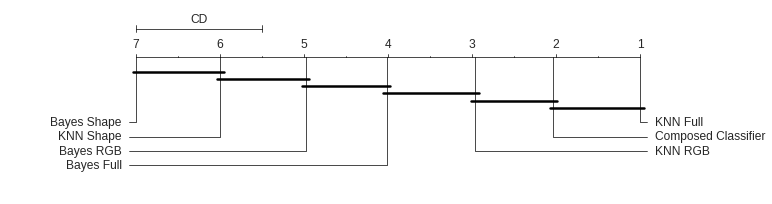

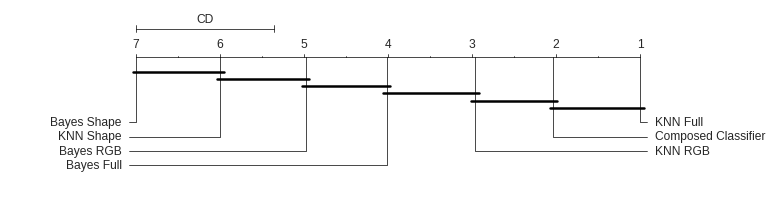

In [16]:
import Orange as orange
names = ["Bayes Full", "KNN Full", "Bayes RGB", "KNN RGB", "Bayes Shape", "KNN Shape", "Composed Classifier"]
avranks = ranks
#### PAY ATTENTION ON THIS VARIABLE, REMEMBER TO CHANGE IT WHEN SOMETHING CHANGES
num_of_datasets = 30

print(ranks)

cd_ten = orange.evaluation.compute_CD(avranks, num_of_datasets, alpha='0.1', test="nemenyi")
cd_five = orange.evaluation.compute_CD(avranks, num_of_datasets, alpha='0.05', test="nemenyi") 


print('p - 0.10')
print('CD: ' + str(cd_ten))
orange.evaluation.graph_ranks(avranks, names, cd=cd_ten, width=10, textspace=1.5, reverse=True)


print('p - 0.05')
print('CD: ' + str(cd_five))
orange.evaluation.graph_ranks(avranks, names, cd=cd_five, width=10, textspace=1.5,reverse=True)


